# Challenge Description

Company XYZ is an online grocery store. In the current version of the website, they have
manually grouped the items into a few categories based on their experience.
However, they now have a lot of data about user purchase history. Therefore, they would like to
put the data into use!

### My Goal

This is what they asked you to do:

- The company founder wants to meet with some of the best customers to go through a
focus group with them. You are asked to send the ID of the following customers to the
founder:
    - the customer who bought the most items overall in her lifetime
    - for each item, the customer who bought that product the most

- Cluster items based on user co-purchase history. That is, create clusters of products that
have the highest probability of being bought together. The goal of this is to replace the
old/manually created categories with these new ones. Each item can belong to just one
cluster.

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
warnings.simplefilter('ignore')

In [2]:
item_to_id = pd.read_csv('day9.csv')
purchase_history = pd.read_csv('day9_2.csv')

In [3]:
item_to_id.head(5)

,Item_name,Item_id
0,coffee,43
1,tea,23
2,juice,38
3,soda,9
4,sandwich loaves,39


In [17]:
print(sorted(item_to_id['Item_id'].unique()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]


In [7]:
purchase_history.head(5)

,user_id,id
0,222087,"27,26"
1,1343649,"6,47,17"
2,404134,"18,12,23,22,27,43,38,20,35,1"
3,1110200,"9,23,2,20,26,47,37"
4,224107,"31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,4..."


In [21]:
def id_to_item(df):
    """ function to convert id into counts """
    # 'sum' here is adding two lists into one big list
    ids = df['id'].str.split(',').sum()
    id_list = [0 for i in range(1, 49)]
    for i in ids:
        id_list[int(i) - 1] += 1
        
    return pd.Series(id_list, index=list(range(1, 49)))

user_item_count = purchase_history.groupby('user_id').apply(id_to_item)

user_item_count.head()

,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
user_id,,,,,,,,,,,,,,,,,,,,,
47,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
68,0,0,0,0,0,1,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
113,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
123,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
223,1,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [40]:
user_count = user_item_count.sum(axis=1).reset_index().rename(columns={0: 'count'})
user_count.sort_values(by='count', ascending=False).head()

,user_id,count
4445,269335,72
6111,367872,70
6623,397623,64
9918,599172,64
6291,377284,63


Thus, the cusomters who bought the most items overall in his lifetime is 269335.

In [44]:
item_user_most = user_item_count.apply(np.argmax, axis=0).reset_index()
item_user_most = item_user_most.rename(columns={'index': 'Item_id', 0: 'User_id'})

df = pd.merge(left=item_user_most, right=item_to_id, on='Item_id', how='left')
df[['Item_id', 'Item_name', 'User_id']]

,Item_id,Item_name,User_id
0,1,sugar,31625
1,2,lettuce,31625
2,3,pet items,154960
3,4,baby items,5289
4,5,waffles,217277
5,6,poultry,334664
6,7,sandwich bags,175865
7,8,butter,151926
8,9,soda,269335
9,10,carrots,618914


#### For each item, the people who bought the most are as above.

In [46]:
feature = user_item_count.T
feature.head()

user_id,47,68,113,123,223,281,323,394,420,453,...,1499502,1499523,1499563,1499702,1499727,1499730,1499778,1499797,1499817,1499974
1,0,0,0,0,1,0,1,1,0,1,...,0,0,1,0,0,0,0,0,1,0
2,1,0,0,0,1,0,0,1,1,1,...,1,0,1,0,0,0,1,0,2,0
3,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [48]:
# determine the best number of clusters
clusters = range(2, 30)
inertias = []
silhouettes = []

for n_clusters in clusters:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, n_jobs=-1)
    kmeans = kmeans.fit(feature)
    label = kmeans.predict(feature)
    
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(feature, label))

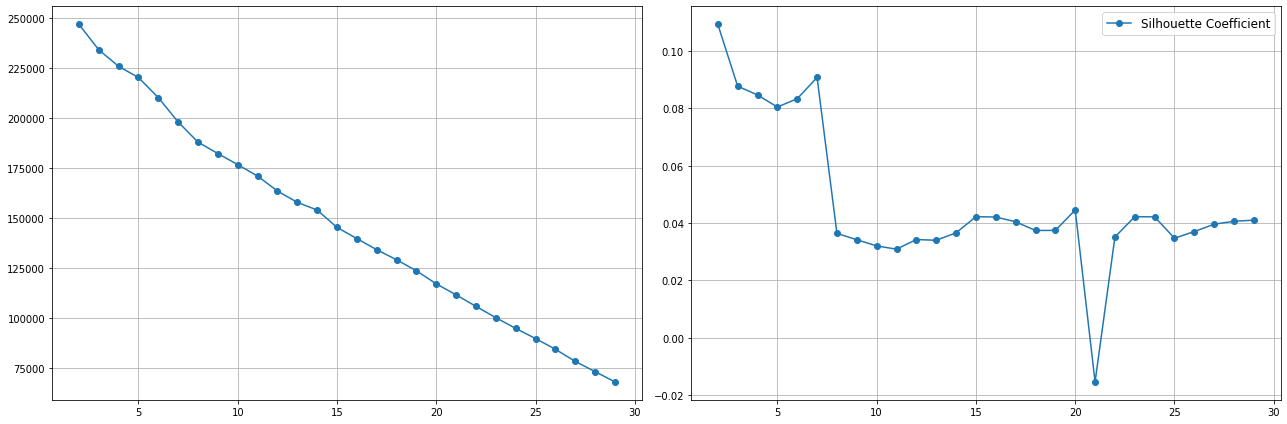

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
ax[0].plot(clusters, inertias, 'o-', label='Sum of Squared Distances')
ax[0].grid(True)
ax[1].plot(clusters, silhouettes, 'o-', label='Silhouette Coefficient')
ax[1].grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [50]:

# build K-Means model
kmeans = KMeans(n_clusters=21, init='k-means++', random_state=42, n_jobs=-1)
kmeans = kmeans.fit(feature)
label = kmeans.predict(feature)

In [51]:
# PCA for dimension reduction
pca = PCA(n_components=2, random_state=42)
pca = pca.fit(feature)
pca_feature = pca.transform(feature)

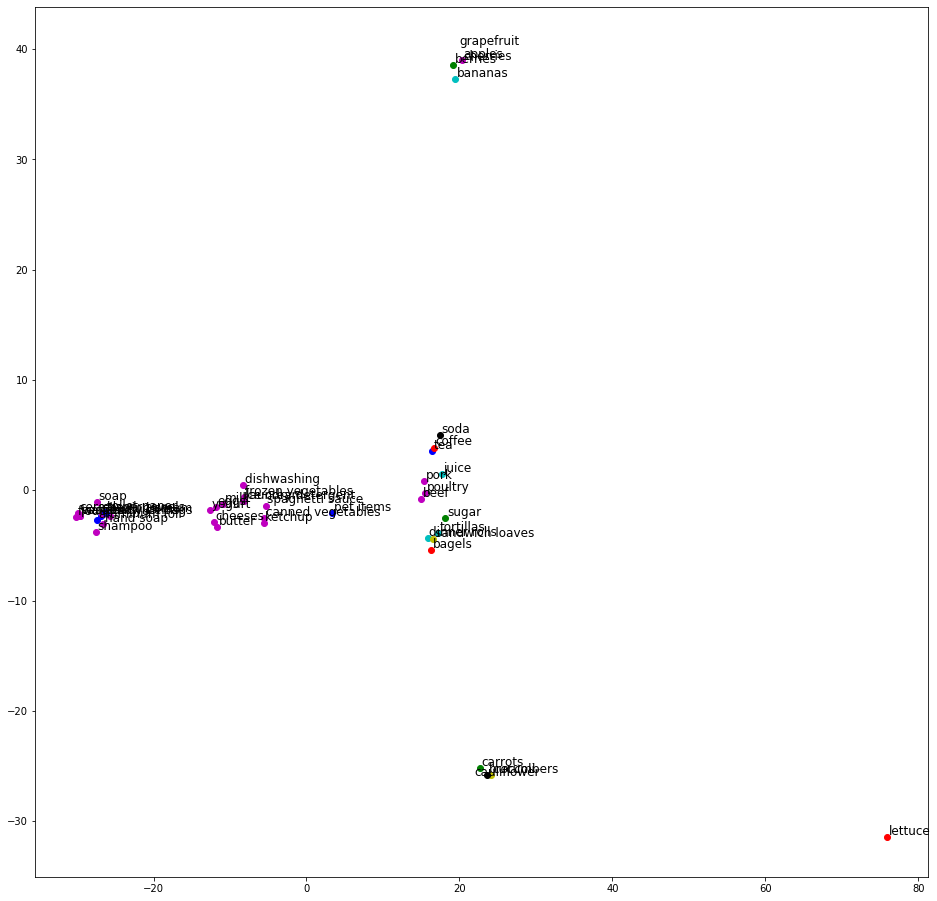

In [53]:
#  visualization in 2D
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

fig, ax = plt.subplots(figsize=(16, 16))
for j in range(len(pca_feature)):
    x = pca_feature[j][0]
    y = pca_feature[j][1]
    ax.plot(x, y, 'o', color=colors[label[j] % 8])
    name = item_to_id[item_to_id['Item_id'] == j + 1]['Item_name']
    ax.annotate(xy=(x+0.2, y+0.2), s=name.values[0], fontsize=12)

plt.show()


In [54]:
# print useful information
df = pd.DataFrame({'Item_id': list(range(1, 49)), 'label': label})
df = pd.merge(left=df, right=item_to_id, on='Item_id', how='left')

for i in range(0, 21):
    print(i, '\t', list(df[df['label'] == i]['Item_name']))

0 	 ['sandwich bags', 'aluminum foil', 'paper towels', 'toilet paper']
1 	 ['sugar']
2 	 ['bagels']
3 	 ['juice']
4 	 ['baby items', 'waffles', 'butter', 'cereals', 'shampoo', 'eggs', 'milk', 'laundry detergent', 'shaving cream', 'cheeses', 'frozen vegetables', 'spaghetti sauce', 'dishwashing\xa0', 'canned vegetables', 'hand soap', 'flour', 'pasta', 'soap', 'ice cream', 'ketchup', 'yogurt']
5 	 ['cucumbers']
6 	 ['broccoli']
7 	 ['cauliflower']
8 	 ['tea']
9 	 ['berries']
10 	 ['lettuce']
11 	 ['bananas']
12 	 ['poultry', 'beef', 'pork']
13 	 ['sandwich loaves']
14 	 ['soda']
15 	 ['grapefruit', 'cherries']
16 	 ['pet items']
17 	 ['carrots']
18 	 ['coffee']
19 	 ['tortillas', 'dinner rolls']
20 	 ['apples']
